# Advanced Models for Semantic Similarity Predictions

Dataset: [Semantic Similarity Predictions for Phrases in U.S. Patents](https://www.kaggle.com/competitions/us-patent-phrase-to-phrase-matching)

This notebook builds off of linear_models.ipynb and trains advanced machine learning models (e.g. Random Forest, Pre-trained Transformer)

* The cosine similarity between spaCy word vectors of the anchor & target phrase from linear_models.ipynb performed the best. However, as discussed in linear_models.ipynb, these 1D feature engineering methods do not show clear trends, thus, more advanced models is not expected to improve accuracy. This notebook fits a Random Forest Regressor & Classifier using the spaCy word vector multiplication feature engineering method.

* A pre-trained Transformer will also be fine-tuned to this dataset in this notebook.

### Preprocessing
---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy

from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.metrics import auc, roc_curve, precision_recall_curve
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
df_train_val = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')
df_titles = pd.read_csv('./data/titles.csv')

df_train, df_val = train_test_split(df_train_val, test_size=0.2, random_state=1)

In [3]:
lm = WordNetLemmatizer()
ps = PorterStemmer()

def lemmatize(text):
    return lm.lemmatize(text)

def stem(text):
    return ps.stem(text)

def remove_stopwords(tokens):
    tokens = [token.lower().strip() for token in tokens]
    filtered_tokens = [token for token in tokens if token not in stopwords.words('english')]
    return filtered_tokens

def preprocess(sent, method='lem'):
    tokens = word_tokenize(sent)
    filtered_tokens = remove_stopwords(tokens)
    
    if method == 'lem':
        tokens = [lemmatize(token) for token in filtered_tokens]
    else:
        tokens = [stem(token) for token in filtered_tokens]

    return ' '.join(tokens)

In [4]:
%%time
df_train['preproc_anchor'] = df_train['anchor'].apply(lambda x: preprocess(x))
df_train['preproc_target'] = df_train['target'].apply(lambda x: preprocess(x))

df_val['preproc_anchor'] = df_val['anchor'].apply(lambda x: preprocess(x))
df_val['preproc_target'] = df_val['target'].apply(lambda x: preprocess(x))

CPU times: user 9.7 s, sys: 1.17 s, total: 10.9 s
Wall time: 10.9 s


#### X_train & y_train

In [5]:
y_train = df_train['score'].to_numpy().reshape(-1, 1)
y_val = df_val['score'].to_numpy().reshape(-1, 1)

In [6]:
# Encode first before binarize, binarize doesnt supporting floating point classes (e.g., 0.00, 0.25, etc)
le = LabelEncoder()
y_train_enc = le.fit_transform(df_train['score'])
y_val_enc = le.transform(df_val['score'])

In [7]:
y_train_bin = label_binarize(y_train_enc, classes=np.arange(0, 5))
y_val_bin = label_binarize(y_val_enc, classes=np.arange(0, 5))

In [8]:
nlp = spacy.load('en_core_web_lg')

def get_feature_vecs(df, model, vec_len=100, model_type='spacy'):
    mult = np.empty((0, vec_len), np.float32)
    cos_sim = np.empty((0, 0), np.float32)
    euc_dist = np.empty((0, 0), np.float32)

    for ind, row in df.iterrows():
        anchor_phrase = row['preproc_anchor']
        target_phrase = row['preproc_target']

        if model_type == 'spacy':
            anchor_vecs = np.array([nlp(word).vector for word in anchor_phrase.split(' ')])
            target_vecs = np.array([nlp(word).vector for word in target_phrase.split(' ')])
        elif model_type == 'gensim':
            anchor_vecs = np.array([model.wv[word] for word in anchor_phrase.split(' ')])
            target_vecs = np.array([model.wv[word] for word in target_phrase.split(' ')])
        
        avg_anchor_vecs = np.average(anchor_vecs, axis=0).reshape(1, -1)
        avg_target_vecs = np.average(target_vecs, axis=0).reshape(1, -1)

        feature_vec = np.multiply(avg_anchor_vecs, avg_target_vecs)

        mult = np.append(mult, feature_vec.reshape(1, vec_len), axis=0)
        cos_sim = np.append(cos_sim, cosine_similarity(avg_anchor_vecs, avg_target_vecs).flatten())
        euc_dist = np.append(euc_dist, np.sqrt(np.sum(np.square(avg_anchor_vecs - avg_target_vecs))))

    return mult, cos_sim.reshape(-1, 1), euc_dist.reshape(-1, 1)

In [9]:
%%time
X_train_mult, X_train_cos, X_train_euc = get_feature_vecs(df_train, nlp, vec_len=300)
X_val_mult, X_val_cos, X_val_euc = get_feature_vecs(df_val, nlp, vec_len=300)

CPU times: user 6min 24s, sys: 35 s, total: 6min 59s
Wall time: 6min 59s


### Helper Functions
---

In [10]:
def plot_roc_auc(y_true, y_pred, labels, model_name, file_path, figsize=(15, 10)):
    
    areas = []

    fig, ax = plt.subplots(1, 1, figsize=figsize)
    for i, lbl in enumerate(labels):
        fpr, tpr, thresholds = roc_curve(y_true[:, i], y_pred[:, i])
        areas.append(auc(fpr, tpr))
        ax.plot(fpr, tpr, label = 'Score = %.2f (AUC: %0.5f)'  % (lbl, areas[i]))

    ax.legend()
    ax.set_title('ROC Curves - ' + model_name);
    ax.set_xlabel('False Positive Rate (FPR)');
    ax.set_ylabel('True Positive Rate (TPR)');
    fig.savefig(file_path)
    plt.close(fig)

    return areas


def plot_precision_recall_auc(y_true, y_pred, labels, model_name, file_path, figsize=(15, 10)):

    areas = []

    fig, ax = plt.subplots(1, 1, figsize=figsize)
    for i, lbl in enumerate(labels):
        pr, rc, thresholds = precision_recall_curve(y_true[:, i], y_pred[:, i])
        areas.append(auc(rc, pr))
        ax.plot(rc, pr, label = 'Score = %s (AUC: %0.5f)'  % (lbl, areas[i]))

    ax.legend()
    ax.set_title('Precision-Recall Curve - ' + model_name);
    ax.set_xlabel('Recall');
    ax.set_ylabel('Precision');
    fig.savefig(file_path)
    plt.close(fig)

    return areas


def plot_auc(labels, values, title):
    plt.figure(figsize=(8, 5))
    fig = plt.bar([str('%.2f' % x) for x in labels], values)
    plt.xlabel('Label')
    plt.ylabel('AUC')
    plt.title(title)
    plt.bar_label(fig, fmt='%.4f')

In [14]:
def return_scores(y_val, y_pred, print_output=True):
    r2s = r2_score(y_val, y_pred)
    rmse = mean_squared_error(y_val, y_pred, squared=False)

    if print_output:
        print("R^2 Score: %.4f" % r2s)
        print("RMSE: %.4f" % rmse)
        print()
    return r2s, rmse


def fit_rf_regressor_rand(X_train, y_train, X_val, y_val, param_dist, feature_eng_method, print_output=True):
    scores = []
    
    reg = RandomForestRegressor(random_state=1)
    random_search = RandomizedSearchCV(reg, param_distributions=param_dist, n_iter=200, scoring='neg_root_mean_squared_error', cv=3, random_state=1, n_jobs=4)
    random_search.fit(X_train, y_train)

    best_reg = random_search.best_estimator_
    y_pred = best_reg.predict(X_val)

    print('METRICS ON VALIDATION DATASET:')
    r2s, rmse = return_scores(y_val, y_pred, print_output=print_output)
    scores.append([feature_eng_method, 'random_forest_randomized', r2s, rmse])

    return random_search.best_params_, scores


def fit_rf_classifier_rand(X_train, y_train, X_val, y_val, param_dist, labels, model_name, output_dir):
    scores = []
    
    reg = OneVsRestClassifier(RandomForestClassifier(random_state=1))
    random_search = RandomizedSearchCV(reg, param_distributions=param_dist, n_iter=200, scoring='roc_auc_ovr', cv=3, random_state=1, n_jobs=4)
    random_search.fit(X_train, y_train)

    best_reg = random_search.best_estimator_
    y_pred = best_reg.predict(X_val)

    auroc = plot_roc_auc(y_val, y_pred, labels, model_name, output_dir + '/roc-' + model_name + '.jpg')
    aupr = plot_precision_recall_auc(y_val, y_pred, labels, model_name, output_dir + '/pr-' + model_name + '.jpg')

    print('AUROC & AUPR FOR VALIDATION DATASET PLOTTED BELOW')
    print()
    plot_auc(labels, auroc, 'AUROC')
    plot_auc(labels, aupr, 'AUPR')

    scores = [[model_name], auroc, aupr, [np.mean(auroc), np.mean(aupr)]]
    return random_search.best_params_, [x for sublist in scores for x in sublist]

In [12]:
rmse_cols = ['feature_eng_method', 'regression_model', 'r2_score', 'rmse']
df_rmse = pd.DataFrame(columns=rmse_cols)

In [13]:
auroc = ['auroc_%.2f' % x for x in np.linspace(0, 1, 5)]
aupr = ['aupr_%.2f' % x for x in np.linspace(0, 1, 5)]
avg = ['avg_auroc', 'avg_aupr']
auc_cols = [x for sublist in [['feature_eng_method'], auroc, aupr, avg] for x in sublist]

df_auc = pd.DataFrame(columns=auc_cols)

### Random Forest
---

#### Regressor

In [15]:
%%time
rand_param_dist = {
    'n_estimators': [100, 150, 200],
    'criterion': ['squared_error', 'poisson'],
    'max_depth': [None, 2, 16, 64, 256],
    'min_samples_split': [2, 16, 64, 256],
    'min_samples_leaf': [1, 10, 100],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True],
    'max_leaf_nodes': [None, 2, 16, 64, 256],
}

params, scores = fit_rf_regressor_rand(X_train_mult, y_train.ravel(), X_val_mult, y_val.ravel(), param_dist=rand_param_dist, feature_eng_method='spacy_vec_mult')
df_rmse = pd.concat([df_rmse, pd.DataFrame(scores, columns=rmse_cols)], axis=0).drop_duplicates()

print('BEST PARAMETERS:')
print(params)

METRICS ON VALIDATION DATASET:
R^2 Score: 0.4001
RMSE: 0.2026

BEST PARAMETERS:
{'n_estimators': 150, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_leaf_nodes': None, 'max_features': 'sqrt', 'max_depth': 64, 'criterion': 'poisson', 'bootstrap': True}
CPU times: user 1min 5s, sys: 507 ms, total: 1min 6s
Wall time: 26min 17s


#### Classifier

/Users/tungnguyen/miniforge3/envs/nlp/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


AUROC & AUPR FOR VALIDATION DATASET PLOTTED BELOW

BEST PARAMETERS:
{'estimator__n_estimators': 150, 'estimator__min_samples_split': 2, 'estimator__min_samples_leaf': 10, 'estimator__max_leaf_nodes': None, 'estimator__max_features': 'sqrt', 'estimator__max_depth': None, 'estimator__criterion': 'entropy', 'estimator__bootstrap': True}
CPU times: user 5min 14s, sys: 789 ms, total: 5min 15s
Wall time: 2h 34min 42s


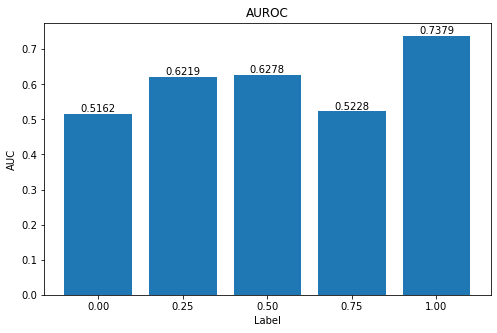

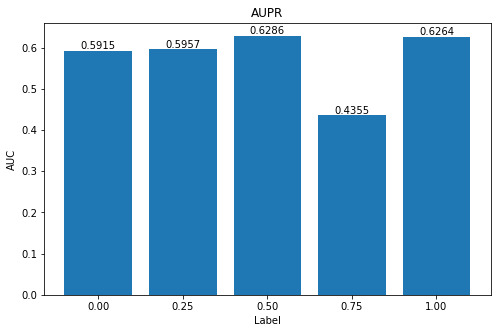

In [17]:
%%time
rand_param_dist = {
    'estimator__n_estimators': [100, 150, 200],
    'estimator__criterion': ['gini', 'entropy'],
    'estimator__max_depth': [None, 2, 16, 64, 256],
    'estimator__min_samples_split': [2, 16, 64, 256],
    'estimator__min_samples_leaf': [1, 10, 100],
    'estimator__max_features': ['sqrt', 'log2'],
    'estimator__bootstrap': [True],
    'estimator__max_leaf_nodes': [None, 2, 16, 64, 256],
}

params, scores = fit_rf_classifier_rand(X_train_mult, y_train_bin, X_val_mult, y_val_bin, param_dist=rand_param_dist, labels=np.linspace(0, 1, 5), model_name='rf_rand_spacy_vec_mult', output_dir=r'./results/')
df_auc = pd.concat([df_auc, pd.DataFrame([scores], columns=auc_cols)], axis=0).drop_duplicates()

print('BEST PARAMETERS:')
print(params)

#### GridSearch

In [18]:
def fit_rf_regressor_grid(X_train, y_train, X_val, y_val, param_dist, feature_eng_method, print_output=True):
    scores = []
    
    reg = RandomForestRegressor(random_state=1)
    grid_search = GridSearchCV(reg, param_grid=param_dist, scoring='neg_root_mean_squared_error', cv=3, n_jobs=4)
    grid_search.fit(X_train, y_train)

    best_reg = grid_search.best_estimator_
    y_pred = best_reg.predict(X_val)

    print('METRICS ON VALIDATION DATASET:')
    r2s, rmse = return_scores(y_val, y_pred, print_output=print_output)
    scores.append([feature_eng_method, 'random_forest_grid', r2s, rmse])

    return grid_search.best_params_, scores


def fit_rf_classifier_grid(X_train, y_train, X_val, y_val, param_dist, labels, model_name, output_dir):
    scores = []
    
    reg = OneVsRestClassifier(RandomForestClassifier(random_state=1))
    grid_search = GridSearchCV(reg, param_grid=param_dist, scoring='roc_auc_ovr', cv=3, n_jobs=4)
    grid_search.fit(X_train, y_train)

    best_reg = grid_search.best_estimator_
    y_pred = best_reg.predict(X_val)

    auroc = plot_roc_auc(y_val, y_pred, labels, model_name, output_dir + '/roc-' + model_name + '.jpg')
    aupr = plot_precision_recall_auc(y_val, y_pred, labels, model_name, output_dir + '/pr-' + model_name + '.jpg')

    print('AUROC & AUPR FOR VALIDATION DATASET PLOTTED BELOW')
    print()
    plot_auc(labels, auroc, 'AUROC')
    plot_auc(labels, aupr, 'AUPR')

    scores = [[model_name], auroc, aupr, [np.mean(auroc), np.mean(aupr)]]
    return grid_search.best_params_, [x for sublist in scores for x in sublist]

In [20]:
%%time
grid_param_dist = {
    'n_estimators': [150],
    'criterion': ['poisson'],
    'max_depth': [56, 60, 64, 68, 72],
    'min_samples_split': [2, 4, 8],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt'],
    'bootstrap': [True],
    'max_leaf_nodes': [None],
}

params, scores = fit_rf_regressor_grid(X_train_mult, y_train.ravel(), X_val_mult, y_val.ravel(), param_dist=grid_param_dist, feature_eng_method='grid_spacy_vec_mult')
df_rmse = pd.concat([df_rmse, pd.DataFrame(scores, columns=rmse_cols)], axis=0).drop_duplicates()

print('BEST PARAMETERS:')
print(params)

METRICS ON VALIDATION DATASET:
R^2 Score: 0.4002
RMSE: 0.2026

BEST PARAMETERS:
{'bootstrap': True, 'criterion': 'poisson', 'max_depth': 56, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
CPU times: user 1min 4s, sys: 199 ms, total: 1min 4s
Wall time: 20min 13s


AUROC & AUPR FOR VALIDATION DATASET PLOTTED BELOW

BEST PARAMETERS:
{'estimator__bootstrap': True, 'estimator__criterion': 'entropy', 'estimator__max_depth': None, 'estimator__max_features': 'sqrt', 'estimator__max_leaf_nodes': None, 'estimator__min_samples_leaf': 6, 'estimator__min_samples_split': 2, 'estimator__n_estimators': 150}
CPU times: user 5min 31s, sys: 1.47 s, total: 5min 32s
Wall time: 45min 43s


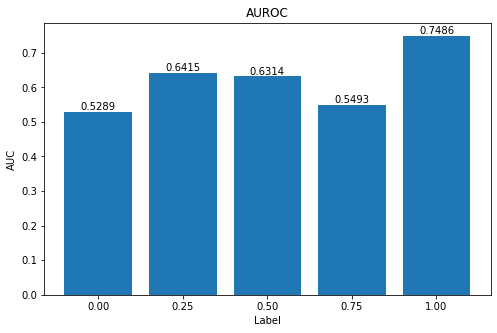

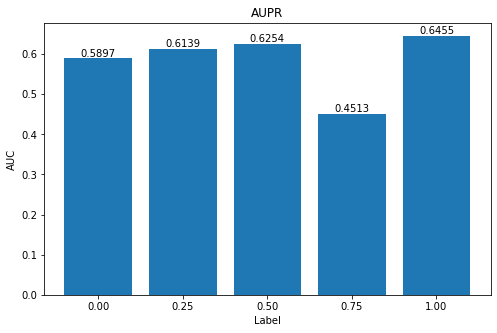

In [21]:
%%time
grid_param_dist = {
    'estimator__n_estimators': [150],
    'estimator__criterion': ['entropy'],
    'estimator__max_depth': [None],
    'estimator__min_samples_split': [2, 4, 6, 8],
    'estimator__min_samples_leaf': [6, 8, 10, 12, 14],
    'estimator__max_features': ['sqrt'],
    'estimator__bootstrap': [True],
    'estimator__max_leaf_nodes': [None],
}

params, scores = fit_rf_classifier_grid(X_train_mult, y_train_bin, X_val_mult, y_val_bin, param_dist=grid_param_dist, labels=np.linspace(0, 1, 5), model_name='rf_grid_spacy_vec_mult', output_dir=r'./results/')
df_auc = pd.concat([df_auc, pd.DataFrame([scores], columns=auc_cols)], axis=0).drop_duplicates()

print('BEST PARAMETERS:')
print(params)

### Pre-trained Transformer (BERT for Sequence Classification)
---

Due to Tensorflow issues on macOS with an M1 chip, the transformer model was trained on Google Colab. View the training notebook [here](https://colab.research.google.com/drive/10cUt5uOLPzXiogx0PLI1S2MFJsASRswm?usp=sharing) (without text preprocessing) and [here](https://colab.research.google.com/drive/1c-ySbgzDvdHdatKId40tvR_OxNWssPxX?usp=sharing) (with text preprocessing) .

#### Without Preprocessing (Raw Text)

In [5]:
df_bert = pd.read_csv(r'./results/bert/without_preproc/areas.csv')
df = df_bert[df_bert.epoch == 4]

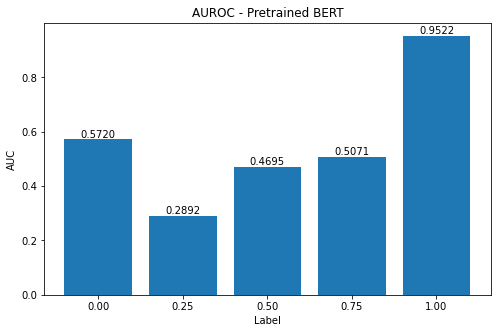

In [15]:
plot_auc(np.linspace(0, 1, 5), df[auroc].values.tolist()[0], 'AUROC - Pretrained BERT')

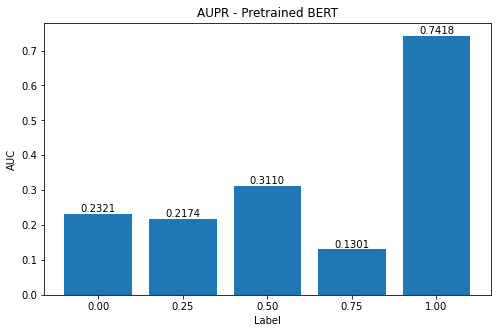

In [17]:
plot_auc(np.linspace(0, 1, 5), df[aupr].values.tolist()[0], 'AUPR - Pretrained BERT')

ROC and PR curves on the validation dataset is plotted below for the BERT model:

![image](./results/bert/without_preproc/roc_epoch_4.jpg)
![image](./results/bert/without_preproc/prc_epoch_4.jpg)

#### With Preprocessing (Text Normalization)

In [10]:
df_bert = pd.read_csv(r'./results/bert/with_preproc/areas.csv')
df = df_bert[df_bert.epoch == 10]

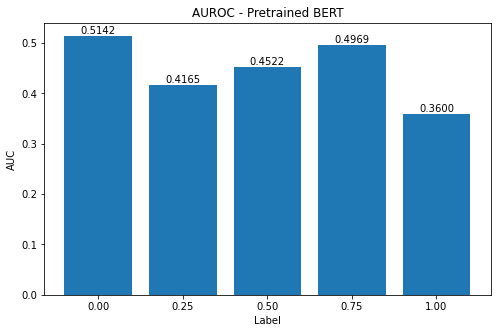

In [11]:
plot_auc(np.linspace(0, 1, 5), df[auroc].values.tolist()[0], 'AUROC - Pretrained BERT')

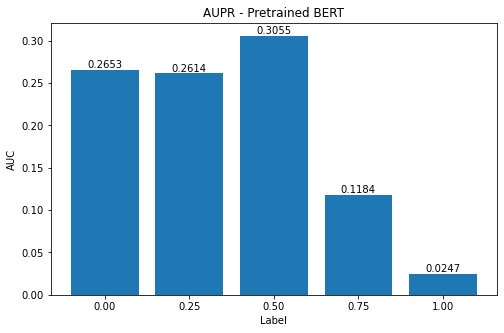

In [12]:
plot_auc(np.linspace(0, 1, 5), df[aupr].values.tolist()[0], 'AUPR - Pretrained BERT')

ROC and PR curves on the validation dataset is plotted below for the BERT model:

![image](./results/bert/with_preproc/roc_epoch_10.jpg)
![image](./results/bert/with_preproc/prc_epoch_10.jpg)

### Conclusions
---

* The Random Forest Regressor performs slightly better than the logistic regression model, with an RMSE of ~0.2 vs. logistic's ~0.23 for the same feature engineering approach.

* The Random Forest Classifier model also performs better, with AUPR ~0.4 - 0.6 vs. logistic's AUPR ~0.2 - 0.5

* Further experimentation could be done to improve the Random Forest models, however, it is clear that pre-trained word vectors alone do not make good features for semantic similarity tasks. 

* If resources were available, custom-trained word vectors may perform better (more suited for technical language than a general pre-trained model)

* The BERT model was only trained for a few epochs and performed worse than Random Forest model for the same feature engineering approach.

* The BERT model also exhibits similar behavior to the logistic regression models from linear_models.ipynb - AUC is high for Score = 1 (e.g. extremely similar phrases) but relatively low for all other scores

    * This most likely is due to the fact that phrases in Score = 1 tend to have more words in common, e.g. activating position vs activation position
    
    * Similar to the Random Forest, further experimentation could be done to improve BERT's accuracy (e.g. experimenting with different text preprocessing steps, learning rate, different transformer architectures, train for more epochs, etc)

* When the text is preprocessed, the BERT model performs poorly. A quick [google search](https://www.researchgate.net/post/Do_you_need_to_preprocess_text_for_BERT) tells us that a pre-trained BERT model uses all information present in the sentence (incl. punctuation) + uses a wordpiece model, so lemmatization or stemming is not necessary.